## Autoencoders Lab - Jan 2022
##### Marcin Kierczak marcin.kierczak@scilifelab.se

# Visualizing HapMap phase 3 populations

---

**Synopsis**

In this lab, we will use chip genotyping data from the HapMap project (phase 3). These data come from a number of humans belonging to different ethnic groups/populations. The groups are genetically distinct but, in some cases, closely related and thus somewhat difficult to distinguish. First, we will try to visualize population structure using classical dimensionality reduction techniques (PCA, MDS). Next, we will build an autoencoder model and see whether it does any different (better or worse) in separating different populations. Throughout the entire lab, we will be using Keras interface to TensorFlow.

---

### **Background**

The purpose of this lab is to evaluate the possibility of using autoencoders as a replacement/complement to more mainstream linear dimensionality reduction methods including as PCA or MDS. These are commonly used for, e.g. visualizing population structure in genetics. 

One of our main motivations is that when inferring genomic kinship from a large number of markers M (large enough to capture population structure at fine level), one necessarily introduces correlations between variables, here, genetic markers. This is predominantly due to the linkage disequilibrium, but also due to the large M that, even by pure chance, introduces correlated variables to the data. This correlation structure introduces non-linearity that, in turn, makes the data not so well suitable for PCA/MDS. The reason being that both PCA and MDS rely on computing kinship matrix determinants that, for a lot of highly correlated variables, become 0 and prevent us from computing exact solutions (division by zero is undefined).

### **Data** 

Here, the working hypotheses is that by choosing non-linear activation functions, e.g. *ReLU,* one can circumvent the variable correlation problem and use autoencoder approach to reduce the dimensionality by embedding kinship data in a low-dimensional *latent representation space* that, in turn, can be easily visualized. The idea emerged during the EMBL conference Reconstructing the Human Past, Heidelberg 🍺, April 2019, in a number of discussions with Nikolay Oskolkov 👨‍🔬 and other conference participants: 🐿, 🦓 and 🐉. It has been further developed during a number of workshops and courses.

Data comes from the HapMap Phase 3 project. Here, for computational feasibility, we will be using smaller dataset, a subset of the original data. I have pre-selected 5,000 autosomal markers with call rate of 100%. We will not be dealing with missing data here although autoencoders, in contrast to PCA and MDS, can which is another argument for using them for our purpose.

HapMap 3 populations:

* ASW – African 🌍 ancestry in Southwest USA 🇺🇸
* CEU – Utah residents with Northern and Western European 🌍 ancestry from the CEPH collection
* CHB – Han Chinese in Beijing, China 🇨🇳
* CHD – Chinese 🇨🇳 in Metropolitan Denver, Colorado ⛰
* GIH – Gujarati Indians 🇮🇳 in Houston, Texas
* JPT – Japanese in Tokyo, Japan 🇯🇵
* LWK – Luhya in Webuye, Kenya 🇰🇪
* MEX – Mexican 🇲🇽 ancestry in Los Angeles, California 🐻
* MKK – Maasai in Kinyawa, Kenya 🇰🇪
* TSI – Toscans 🛵 in Italy 🇮🇹
* YRI – Yoruba in Ibadan, Nigeria 🇳🇬

### Step 0 &mdash; getting the data

First, we will download the data from the linked Dropbox account.



In [1]:
#@title Load raw data. Double click to see the code. { display-mode: "form" }

!wget https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
!wget https://www.dropbox.com/s/3lv0062dw20qdqg/autosomal_5k_phenos.csv
!wget https://www.dropbox.com/s/6nzrusxkm536a5j/autosomal_5k_kinship.csv

--2022-01-17 16:09:38--  https://www.dropbox.com/s/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/g7862q1l4ls9z3x/autosomal_5k_matrix.csv [following]
--2022-01-17 16:09:38--  https://www.dropbox.com/s/raw/g7862q1l4ls9z3x/autosomal_5k_matrix.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe34fb905fccecdaed345c02e5.dl.dropboxusercontent.com/cd/0/inline/Bd-bU7sFtblA-1ADv2gk_iQZ-qps2Lt9fIK3DPLmduMZgtjOpSZ0QBJwuBK-vyePtYUDA_3XISf1A7fXzOkRo9YC1u7taJICIrbRWxgSu_r1EvhPUfghL-zq4ZiyfXLKxYUUiB7EL-55rBMXyajX2fxf/file# [following]
--2022-01-17 16:09:39--  https://ucbe34fb905fccecdaed345c02e5.dl.dropboxusercontent.com/cd/0/inline/Bd-bU7sFtblA-1ADv2gk_iQZ-qps2Lt9fIK3DPLmduMZgtjOpSZ0QBJwu

Now, we will load the data and make sure they look as expected. Note, the genotypes per individual (row) are encoded as the count of minor alleles and thus can take values `gt = {0, 1, 2}`. 

**Q1** How many individuals do we have in the dataset?  
**Q2** How many individuals per population do we have? Do they have the same number of males and females?  


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

geno = pd.read_csv("autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("autosomal_5k_phenos.csv", header=0, index_col=0)

print(geno)
print(pheno)


         rs416967  rs17013842  rs13052452  ...  rs317892  rs11937009  rs2806497
NA19919         2           1           0  ...         1           1          0
NA19916         1           0           0  ...         1           1          0
NA19835         0           0           1  ...         2           0          0
NA20282         1           1           0  ...         2           0          0
NA19703         0           0           0  ...         1           2          0
...           ...         ...         ...  ...       ...         ...        ...
NA19119         1           0           1  ...         1           0          0
NA18860         1           0           0  ...         0           0          1
NA19207         2           0           0  ...         1           1          0
NA19103         1           0           1  ...         1           2          0
NA19099         0           0           1  ...         1           0          0

[1184 rows x 5000 columns]
            

In [ ]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,NA20282,0,2469,0,0,0,African ancestry in SW USA
NA19703,NA19703,1,2368,0,0,0,African ancestry in SW USA
...,...,...,...,...,...,...,...
NA19119,NA19119,1,Y060,0,0,0,Yoruba in Ibadan Nigeria
NA18860,NA18860,1,Y012,NA18859,NA18858,0,Yoruba in Ibadan Nigeria
NA19207,NA19207,1,Y051,0,0,0,Yoruba in Ibadan Nigeria
NA19103,NA19103,1,Y042,NA19101,NA19102,0,Yoruba in Ibadan Nigeria


In [ ]:
# Scaling 
# We need to scale our counts data so that it is bound between 0 and 1. 
# Now, the AA homozygotes will be coded as 0, heterozygotes as 0.5 and aa homozygotes as 1. 

geno_data = geno / 2
geno_data

,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,rs11077847,rs2418834,rs3012137,rs6757324,rs10496671,rs2654991,rs4789934,rs2304278,rs7612448,rs6809832,rs13413583,rs1340153,rs10465037,rs6690085,rs11011311,rs6081756,rs9394696,rs2964102,rs2467728,rs11148265,rs540999,rs1348466,rs11702933,rs2350920,rs2706632,rs6041885,rs4515594,rs1860322,rs12722489,rs12081137,...,rs17161128,rs11749133,rs10955172,rs17114871,rs6957177,rs6695787,rs2002009,rs2433109,rs7769505,rs7098362,rs2040575,rs1123740,rs4687809,rs11198182,rs7214689,rs11584771,rs7963379,rs3763114,rs11164850,rs7985080,rs17123706,rs11079874,rs12336214,rs6474973,rs10509669,rs3181,rs7205244,rs12111251,rs4077492,rs7705455,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,1.0,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,0.0,1.0,0.5,1.0,0.0,1.0,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0
NA19916,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.5,0.0,0.5,0.5,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,1.0,0.0,0.0,1.0,0.5,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.5,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0
NA19835,0.0,0.0,0.5,0.5,0.0,0.5,0.0,1.0,1.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,1.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0,0.0,0.0,0.5,1.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
NA20282,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,0.5,1.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0
NA19703,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,1.0,0.0,0.0,...,0.0,0.5,0.0,1.0,1.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,0.5,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.5,0.5,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,1.0,0.5,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
NA18860,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,0.5,0.5,0.5,0.0,0.5,0.0,0.5,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,...,0.0,0.5,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
NA19207,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.5,0.5,0.5,0.0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0
NA19103,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.5,0.5,0.5,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
import math
import random
noisy_data = (geno + 2)/4
noisy_data = noisy_data.applymap(lambda x: 0 if (random.randint(1, 100) <= 1) else x)
print(noisy_data) 

         rs416967  rs17013842  rs13052452  ...  rs317892  rs11937009  rs2806497
NA19919      1.00        0.75        0.50  ...      0.75        0.75       0.50
NA19916      0.75        0.50        0.50  ...      0.75        0.75       0.50
NA19835      0.50        0.50        0.75  ...      1.00        0.50       0.50
NA20282      0.75        0.75        0.50  ...      1.00        0.50       0.50
NA19703      0.50        0.50        0.50  ...      0.75        1.00       0.50
...           ...         ...         ...  ...       ...         ...        ...
NA19119      0.75        0.50        0.75  ...      0.75        0.50       0.50
NA18860      0.75        0.50        0.50  ...      0.50        0.50       0.75
NA19207      1.00        0.50        0.50  ...      0.75        0.75       0.50
NA19103      0.75        0.50        0.75  ...      0.75        1.00       0.50
NA19099      0.50        0.50        0.75  ...      0.75        0.50       0.50

[1184 rows x 5000 columns]


In [ ]:
# Randomly split into the training and the validation set
data = noisy_data
train = data.sample(frac = 0.8, random_state = 42) 
test = data.drop(train.index)
train.reset_index()
test.reset_index()

# Print some info about the resulting split
print("Number of individuals:", data.shape[0])
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Number of individuals: 1184
	 - training set: (947, 5000)
	 - test set: (237, 5000)


In [ ]:
train_tensor = train.to_numpy()
print(type(train_tensor))

# Hyperparameters
hp_loss_fn = 'mse'
hp_act_fn = 'relu'
hp_optimizer = 'adam'
hp_metrics = ['mse','mae','mape']

input_data = keras.Input(shape = train_tensor.shape[1])

def Encoder(input):
  # Encoder
  layer1 = layers.Dense(units = 1500, activation = hp_act_fn, name='layer1')(input)
  layer2 = layers.BatchNormalization(name='layer2')(layer1)
  layer3 = layers.Dropout(rate = 0.05, name='layer3')(layer2)
  layer4 = layers.Dense(units = 250, activation = hp_act_fn, name='layer4')(layer3)
  layer5 = layers.Dropout(rate = 0.025, name='layer5')(layer4)
  layer6 = layers.Dense(units = 25, activation = hp_act_fn, name='layer6')(layer5)
  bottleneck = layers.Dense(units = 2, name='layer_bottleneck')(layer6)
  return(bottleneck)
  
def Decoder(bottleneck):
  # Decoder
  layer7 = layers.Dense(units = 25, activation = hp_act_fn)(bottleneck)
  layer8 = layers.Dropout(rate = 0.025)(layer7)
  layer9 = layers.Dense(units = 250, activation = hp_act_fn)(layer8)
  layer10 = layers.Dropout(rate = 0.05)(layer9)
  layer11 = layers.Dense(units = 1500, activation = hp_act_fn)(layer10)
  layer12 = layers.Dense(units = train_tensor.shape[1], activation = 'sigmoid')(layer11)
  return(layer12)

def Autoencoder(input):
  enc = Encoder(input)
  autoenc = Decoder(enc)
  return(autoenc)

autoencoder_model = keras.Model(inputs = input_data, outputs = Autoencoder(input_data))
autoencoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)
autoencoder_model.summary()

<class 'numpy.ndarray'>
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5000)]            0         
                                                                 
 layer1 (Dense)              (None, 1500)              7501500   
                                                                 
 layer2 (BatchNormalization)  (None, 1500)             6000      
                                                                 
 layer3 (Dropout)            (None, 1500)              0         
                                                                 
 layer4 (Dense)              (None, 250)               375250    
                                                                 
 layer5 (Dropout)            (None, 250)               0         
                                                                 
 layer6 (Dense)              (None,

In [ ]:
# Set hyperparameters
hp_epochs = 30
hp_batch_size = 256
hp_val_split = 0.2

autoencoder = autoencoder_model.fit(x = train_tensor, 
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Epoch 1/30
3/3 [==============================] - 2s 582ms/step - loss: 0.0327 - mse: 0.0327 - mae: 0.0995 - mape: 5002721.0000 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.0992 - val_mape: 5047566.0000
Epoch 2/30
3/3 [==============================] - 1s 457ms/step - loss: 0.0317 - mse: 0.0317 - mae: 0.1002 - mape: 5046116.0000 - val_loss: 0.0283 - val_mse: 0.0283 - val_mae: 0.1031 - val_mape: 5232959.5000
Epoch 3/30
3/3 [==============================] - 1s 463ms/step - loss: 0.0256 - mse: 0.0256 - mae: 0.1068 - mape: 5490941.5000 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1221 - val_mape: 6497732.5000
Epoch 4/30
3/3 [==============================] - 1s 454ms/step - loss: 0.0221 - mse: 0.0221 - mae: 0.1073 - mape: 6030086.5000 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.1076 - val_mape: 6173297.0000
Epoch 5/30
3/3 [==============================] - 1s 455ms/step - loss: 0.0210 - mse: 0.0210 - mae: 0.0995 - mape: 5696509.5000 - val_loss: 0.0225 - val_mse: 0.0225 - v

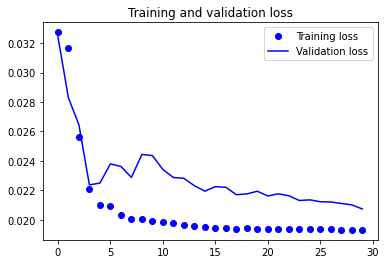

In [ ]:
loss = autoencoder.history['loss']
val_loss = autoencoder.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder_model.save_weights('autoencoder_weights.h5', 
                               overwrite = True)

encoder_model = keras.Model(inputs = input_data, outputs = Encoder(input_data))
encoder_model.load_weights('autoencoder_weights.h5', 
                           skip_mismatch = True, 
                           by_name = True)
encoder_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)


[[-2.875905  -2.3897994]
 [-2.281233  -2.7185616]
 [-2.1611128 -2.1024797]
 ...
 [-2.3171868 -2.332701 ]
 [-2.2005374 -2.406204 ]
 [-2.3834856 -3.0948727]]


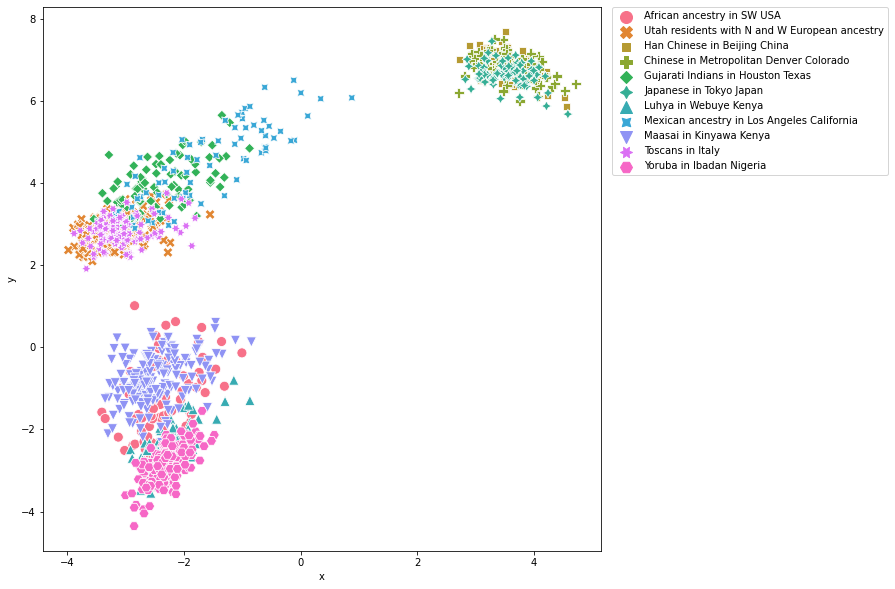

In [ ]:
embeded_points = encoder_model.predict(geno_data.to_numpy()) 
print(embeded_points)

x = embeded_points[:,0]
y = embeded_points[:,1]
pop = pheno2['population']
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

In [ ]:
kinship = pd.read_csv("autosomal_5k_kinship.csv", header=0, index_col=0)
 

In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
mds_embedding = embedding.fit_transform(kinship)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


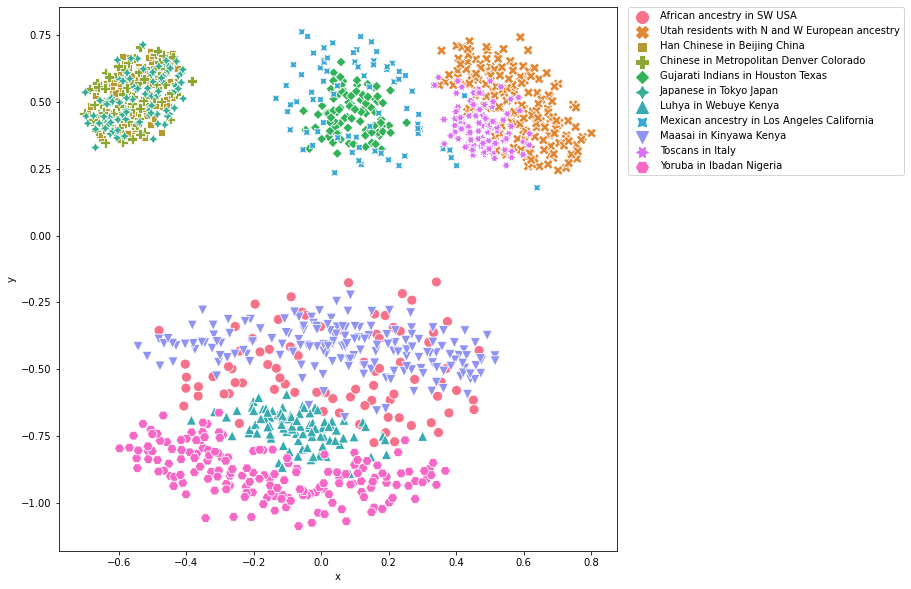

In [ ]:
x = mds_embedding[:,0]
y = mds_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

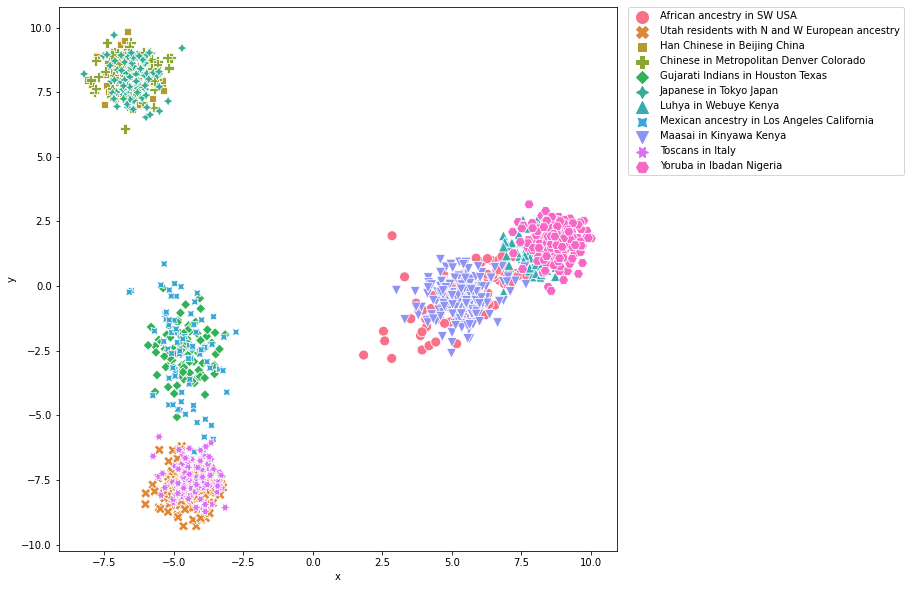

In [ ]:
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno_data * 2)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

### Tasks

Now that you have a working example of an autoencoder, try to experiment with your model. Change hyperparameters, e.g. number of layers, size of layers, optimizer, maybe train for a different number of epochs or more dropouts. See whether your new model performs better or worse.  